# Read Bank Statement from PDF for Personal Finance Managment

### extract data

We use python library `pyPDF2` to extract structured table from pdf printed pandas data frame statement. The code are collapsed into a python class object. 

### analytic

We use python `pandas` for analytic. 

Compares to R, python pandas does have some advantages:
* **Multi-indexed pandas data.frame are more human readable** (Removes the repeated elemen). I consider leaving output of dataframe multi-level indexed, before send in for analysis and visualisaion is probably helpful for debug. 
* However, because pandas's **object methods are very very specific**, it can be a pain to look for specific method for object you don't even know what (am I using a series? or row index). On the other hand the syntax became **more readable**.
* I found the best practice for handing mischevlous data that has too much cases is to record each case and handler to in a list of tuples. And then `pd.map` this function. I call it `Description` in this transformation. The only `ifelse/case_when` equavlent in python is `np.where()`. I have great fear that `map` function will no longer be suitable in handing large `data.frame`. 

## Land Scape of Open Source Fin Tech

- bank-statement-reader, read a pdf bank statement into csv 
- [autobean](https://pypi.org/project/autobean/)

In [1]:
# pip install bank-statement-reader
#!pip install pdf-statement-reader
#!pip uninstall ironpdf
#!pip install PyPDF2
#!pip install textract

Auto bank statement is a command line tool seems. And I don't seems to get it to work. 

Alternative package I found is `texttract` it worked for the first time (I think is since I removed some package I removed that package's dependency).
There are a bundle of dependency you need to install before you do anything. 
see their doc here: [textract](https://textract.readthedocs.io/en/latest/installation.html). 

This turns 

# Extract Data From Bank Statement

In [1]:
import textract
import re
import PyPDF2

In [2]:
# Read a Bank Statement
readerOBJ = open('bank-statement/Statement_2023_9.pdf', 'rb')
pdfReader = PyPDF2.PdfReader(readerOBJ)
print(len(pdfReader.pages))
text = ""
for page in pdfReader.pages:
    text += page.extract_text() + "\n"
print(text)

5
Page 1 of 5logo, Lloyds Bank.
18 September 2023
If you think something is incorrect, please contact us on  0345 300 0000
Lloyds Bank plc. Registered Office: 25 Gresham Street, London EC2V 7HN. Registered in England and Wales no. 2065 Lloyds Bank plc
is authorised by the Prudential Regulation Authority and regulated by the Financial Conduct Authority and the Prudential Regulation
Authority under registration number 119278. We adhere to The Standards of Lending Practice which are monitored and enforced by the
LSB: www.lendingstandardsboard.org.ukDocument requested by:
Mr Fanzhou Liang
33 WYNDHAM AVENUE
EXETER
DEVON
EX1  2PQ
(Address last updated 07 Feb 2022)Your Account
Sort Code 30-80-37
Account Number 53254063
CLASSIC . 01 September 2023 to 18 September 2023 .
Money In . £0.00 .Balance on 01 September 2023 . £5,121.90 .
Money Out . £2,466.00 .Balance on 18 September 2023 . £2,660.90 .
Your Transactions
Column
Date .Column
Description .Column
Type .Column
Money In (£) .Column
Money Ou

In [ ]:
# The Text Tract Method
text_from_tt = textract.process('bank-statement/Statement_2023_9.pdf')
print(text_from_tt.decode()) #draw back is t will alwyas come back as a binary file so you wold need to decode it

In [161]:
re.split('Page \d+ of \d+',text) # The most simple way is probaly just use this as 
pattern = r'(?<=Your Transactions\n)(.*?)(?=\(Continued on next page\))'
transaction_blocks = re.findall(pattern, text, re.DOTALL)
one_page = transaction_blocks[0]
# Actual are seperated by ` .`

I found out that everything in 'transaction_list' is a reoccuring python that could potentially be parsed into a python pandas data frame. The schema is indicated by key (the string before '\n') 'column'. The value (the string after '\n') is column name.  After the schema part are the actual row for this data frame. One row is one element of the list. The column name corresponding that row is indicated by string berfore '\n', the value of the row, that column is indicated by string after '\n'.

In [166]:
import pandas as pd

# Initialize an empty list to store each parsed DataFrame
dfs = []
# Iterate through the transaction_list
for one_page in transaction_blocks:
    # Split the 'all_transaction' text into a list based on the ' .' token
    transaction_list = re.split(' \.|(?<=blank)\.', one_page)

    # Initialize an empty dictionary to store the data in a structured format
    data_dict = {}

    # Initialize a variable to keep track of the current column name
    current_column = None
    for transaction in transaction_list:
        # Split each transaction based on a newline character
        parts = transaction.strip('\n').split('\n', 1)
        
        # Check if the transaction was split into two parts (before and after '\n')
        if len(parts) == 2:
            key, value = parts
            key = key.strip()  # Remove leading/trailing spaces from the key
            value = value.strip()  # Remove leading/trailing spaces from the value
            
            # If the key is 'column', update the current_column
            if key == 'Column':
                current_column = value
                data_dict[current_column] = []  # Initialize an empty list for the new column
            else:
                current_column = key
                # Append the value to the corresponding column in the dictionary
                data_dict[current_column].append(value)

    # Create a Pandas DataFrame from the data_dict
    df = pd.DataFrame(data_dict)
    dfs.append(df)
# Print the DataFrame
bank_statement = pd.concat(dfs, ignore_index=True)

In [167]:
# this method do similar things here. 
#[i.strip('\n').split('\n',1) for i in transaction_list]
bank_statement

,Date,Description,Type,Money In (£),Money Out (£),Balance (£)
0,01 Sep 23,EXETER CITY COUNCI,DD,blank,5.00,"5,121.90"
1,01 Sep 23,EXETER CITY COUNCI,DD,blank,29.80,"5,092.10"
2,01 Sep 23,WATERSTONES,DEB,blank,2.80,"5,089.30"
3,01 Sep 23,Zettle_*The Explod,DEB,blank,6.80,"5,082.50"
4,01 Sep 23,MARKS&SPENCER PLC,DEB,blank,13.00,"5,069.50"
...,...,...,...,...,...,...
74,18 Sep 23,BURGER KING,DEB,blank,8.78,"2,711.89"
75,18 Sep 23,ZETTLE_*130 BASEME,DEB,blank,3.20,"2,708.69"
76,18 Sep 23,MARKS&SPENCER PLC,DEB,blank,8.35,"2,700.34"
77,18 Sep 23,TK MAXX,DEB,blank,14.99,"2,685.35"


In [1]:
from src.bank_transaction_reader import BankTransactionReader

# Example usage:
pdf_file_path = 'bank-statement/Statement_2023_9.pdf'
processor = BankTransactionReader()
pdf_text = processor.extract_text_from_pdf(pdf_file_path)
transaction_blocks = processor.extract_transaction_blocks(pdf_text)
processor.process_transactions(transaction_blocks)
concatenated_df = processor.get_concatenated_dataframe()


In [11]:
from src.bank_transaction_reader import BankTransactionReader as btr
# reader = BankTransactionReader()
# btr.read('bank-statement/Statement_2023_9.pdf')
from src.bank_transaction_reader import *
# reserved this ability of using 
processor = BankTransactionProcesser(r'(?!\d)\.(?<!\d)')
# df = processor.read('bank-statement/Statement_2023_9.pdf')
file_loc = 'bank-statement/Statement_2023_9.pdf'
text = processor.extract_text_from_pdf(file_loc)
tran_bloc=processor.extract_transaction_blocks(text)
tran_bloc
processor.process_transactions(tran_bloc)
# tran_bloc[0].split('.')

In [1]:
from src.bank_transaction_reader import BankTransactionReader as btr
# reader = BankTransactionReader()
btr.read('bank-statement/Statement_2023_9.pdf')

,Date,Description,Type,Money In (£),Money Out (£),Balance (£)
0,01 Sep 23,EXETER CITY COUNCI,DD,blank,5,"5,121"
1,01 Sep 23,EXETER CITY COUNCI,DD,blank,29,"5,092"
2,01 Sep 23,WATERSTONES,DEB,blank,2,"5,089"
3,01 Sep 23,Zettle_*The Explod,DEB,blank,6,"5,082"
4,01 Sep 23,MARKS&SPENCER PLC,DEB,blank,13,"5,069"
...,...,...,...,...,...,...
121,28 Sep 23,NON-GBP TRANS FEE,DEB,blank,0,"3,985"
122,28 Sep 23,NON-GBP PURCH FEE,DEB,blank,0,"3,985"
123,28 Sep 23,STGCOACH/CTYLINK,DEB,blank,2,"3,983"
124,28 Sep 23,COSTA COFFEE 43011,DEB,blank,3,"3,979"


In [2]:
btr.read('bank-statement/Statement_2023_8.pdf')

,Date,Description,Type,Money In (£),Money Out (£),Balance (£)
0,01 Aug 23,EXETER CITY COUNCI,DD,blank,5,"4,802"
1,01 Aug 23,EXETER CITY COUNCI,DD,blank,29,"4,772"
2,01 Aug 23,STEPHEN GIBSON,FPO,blank,350,"4,422"
3,01 Aug 23,STGCOACH/CTYLINK,DEB,blank,2,"4,420"
4,01 Aug 23,COSTA COFFEE 43011,DEB,blank,5,"4,414"
...,...,...,...,...,...,...
143,30 Aug 23,TESCO STORES 2487,DEB,blank,4,"2,858"
144,30 Aug 23,COSTA COFFEE 43011,DEB,blank,5,"2,852"
145,30 Aug 23,HTTPS://MALEFOCUS,DEB,blank,12,"2,840"
146,30 Aug 23,MARKS&SPENCER PLC,DEB,blank,14,"2,826"


In [7]:
from src.bank_transaction_reader import *
processor = BankTransactionProcesser()

# reserved some flexibility of reading multiple bankstemet

processor.read('bank-statement/Statement_2023_8.pdf', reset=False)
processor.read('bank-statement/Statement_2023_9.pdf', reset=False)

7 table are populated.
13 table are populated.


In [389]:
from src.bank_transaction_reader import BankTransactionReader as btr
btr.read('bank-statement/Statement_2023_6.pdf')

,Date,Description,Type,Money In (£),Money Out (£),Balance (£)
0,01 Jun 23,EXETER CITY COUNCI,DD,blank,5,"4,580"
1,01 Jun 23,EXETER CITY COUNCI,DD,blank,29,"4,550"
2,01 Jun 23,STGCOACH/CTYLINK,DEB,blank,2,"4,548"
3,01 Jun 23,V H GRADDON SONS V,DEB,blank,2,"4,546"
4,01 Jun 23,ZETTLE_*SUNDAYS,DEB,blank,3,"4,543"
...,...,...,...,...,...,...
121,29 Jun 23,STGCOACH/CTYLINK,DEB,blank,2,"2,391"
122,29 Jun 23,trainline,DEB,blank,3,"2,387"
123,29 Jun 23,COSTA COFFEE 43011,DEB,blank,5,"2,382"
124,30 Jun 23,FULL FIBRE LIMITED,BGC,"2,198",blank,"4,580"


# Analytic Demo

In [6]:
from src.bank_transaction_reader import BankTransactionReader as btr
import pandas as pd

files = [
    'bank-statement/Statement_2023_6.pdf',
    'bank-statement/Statement_2023_7.pdf',
    'bank-statement/Statement_2023_8.pdf',
    'bank-statement/Statement_2023_9.pdf'
]

df = btr.read(files)

Read additional 7 tables.Total 7 tables populated.
Read additional 8 tables.Total 15 tables populated.
Read additional 8 tables.Total 23 tables populated.
Read additional 7 tables.Total 30 tables populated.


In [7]:
# Create Two Funcions to Clean Numeric Date Time
def clean_numbers(df, col):
    df[col] = df[col].apply(
        lambda x: x.str.replace(',', '').str.replace('blank','0')
    ).astype(float)
    return(df)
def parse_datetime(df, col):
    df[col] = pd.to_datetime(df[col], format='%d %b %y')
    return(df)

In [8]:
# Create New Date Time Object
(
    df
    .pipe(clean_numbers, ['Money In (£)', 'Money Out (£)', 'Balance (£)'])
    .pipe(parse_datetime, 'Date')
)

,Date,Description,Type,Money In (£),Money Out (£),Balance (£)
0,2023-06-01,EXETER CITY COUNCI,DD,0.0,5.0,4580.0
1,2023-06-01,EXETER CITY COUNCI,DD,0.0,29.0,4550.0
2,2023-06-01,STGCOACH/CTYLINK,DEB,0.0,2.0,4548.0
3,2023-06-01,V H GRADDON SONS V,DEB,0.0,2.0,4546.0
4,2023-06-01,ZETTLE_*SUNDAYS,DEB,0.0,3.0,4543.0
...,...,...,...,...,...,...
570,2023-09-29,STGCOACH/CTYLINK,DEB,0.0,2.0,5814.0
571,2023-09-29,PRET A MANGER,DEB,0.0,5.0,5808.0
572,2023-09-29,STGCOACH/CTYLINK,DEB,0.0,2.0,5806.0
573,2023-09-29,MARKS&SPENCER PLC,DEB,0.0,17.0,5789.0


In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plot_params = {'color': '0.75',
 'style': '.-',
 'markeredgecolor': '0.25',
 'markerfacecolor': '0.25',
 'legend': False}

plt.style.use('seaborn-whitegrid')
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

/var/folders/r5/1cdq52mn21zdnqzl0fvp44zw0000gn/T/ipykernel_3029/3224721386.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Text(0.5, 1.0, 'Blance Level')

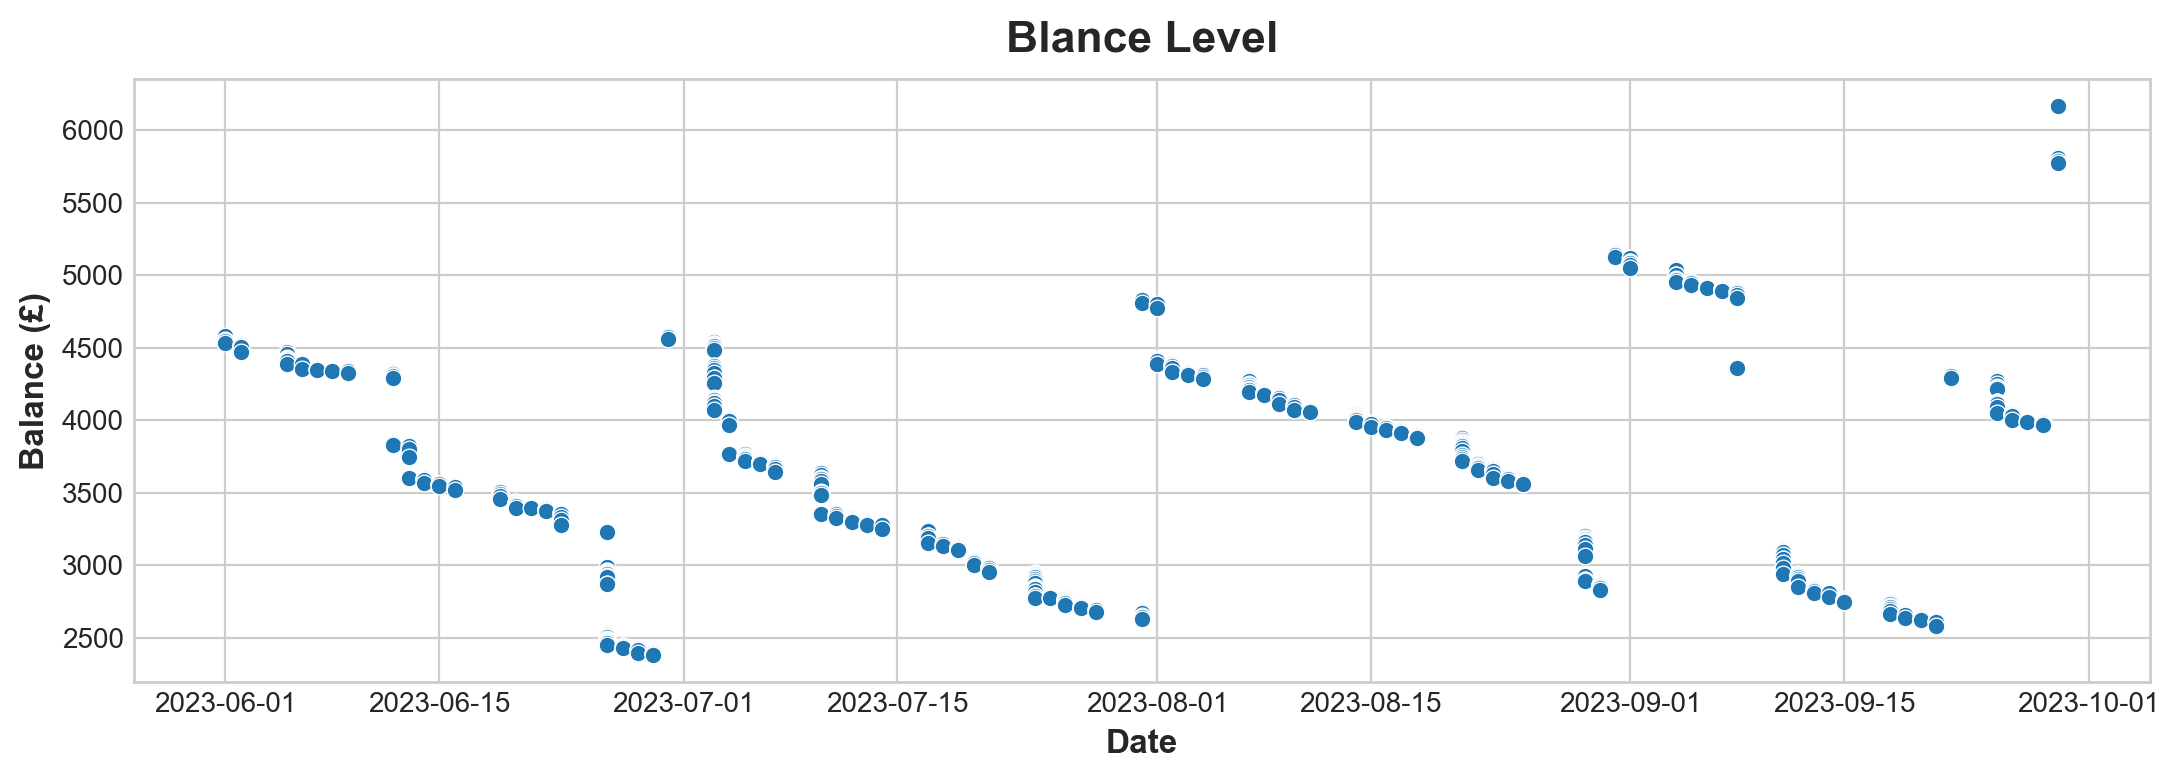

In [18]:
p = sns.scatterplot(
    data = df,
    x = 'Date',
    y = 'Balance (£)'
)
p.set_title('Blance Level')

Text(0.5, 1.0, 'Spending Line Curve')

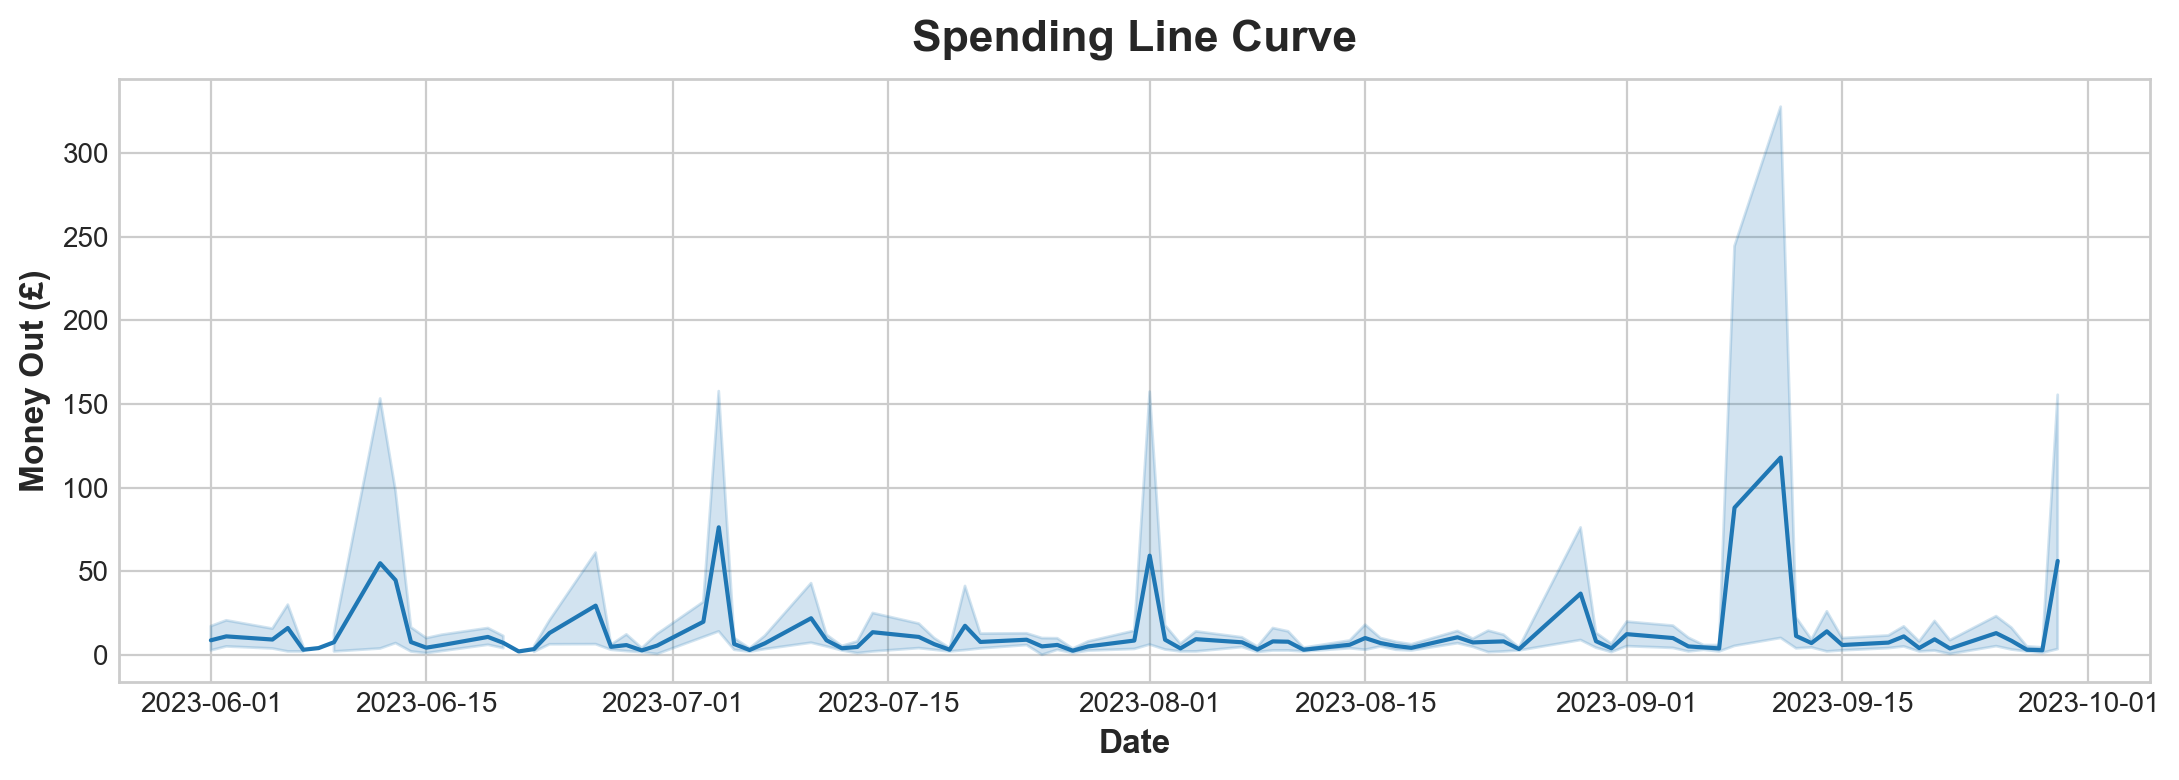

In [8]:
p = sns.lineplot(
    data = df, 
    x = 'Date',
    y = 'Money Out (£)'
)
p.set_title('Spending Line Curve')

This plot don't give you much infor though. Dates are not aggregated rather just give you rough view of transaction frequency. Only interesting if youa re interested in transaction frequency.

In [9]:
(
    df.assign(
        Month = lambda df: df.Date.dt.to_period('M')
        )
      .groupby('Month')
      .agg({
          'Money In (£)':sum,
          'Money Out (£)':sum
          })
      .assign(
          Net_Saving = lambda df: df["Money In (£)"] - df["Money Out (£)"]
      )
)

,Money In (£),Money Out (£),Net_Saving
Month,,,
2023-06,2198.0,2180.0,18.0
2023-07,2207.0,1896.0,311.0
2023-08,2336.0,1960.0,376.0
2023-09,3924.0,3231.0,693.0


,Date,Description,Type,Money In (£),Money Out (£),Balance (£)
34,2023-06-12,ACUITIS OPTICAL &,DEB,0.0,448.0,3844.0
83,2023-06-26,PAYPAL *AIRBNB HM,DEB,0.0,243.0,2987.0
155,2023-07-04,LLL ATHLETICA UK L,DEB,0.0,202.0,3766.0
41,2023-06-13,Nike GBP,DEB,0.0,144.0,3603.0
421,2023-08-29,TED BAKER,DEB,0.0,140.0,2924.0
189,2023-07-10,REISS-EXETER,DEB,0.0,128.0,3356.0
136,2023-07-03,TRAINLINE,DEB,0.0,106.0,4376.0
144,2023-07-03,PAYPAL *AIRBNB HM,DEB,0.0,105.0,4153.0
545,2023-09-25,PAYPAL *GLBE TED B,DEB,0.0,83.0,4128.0
226,2023-07-20,NO ORDINARY DESIGN,DEB,0.0,75.0,3029.0


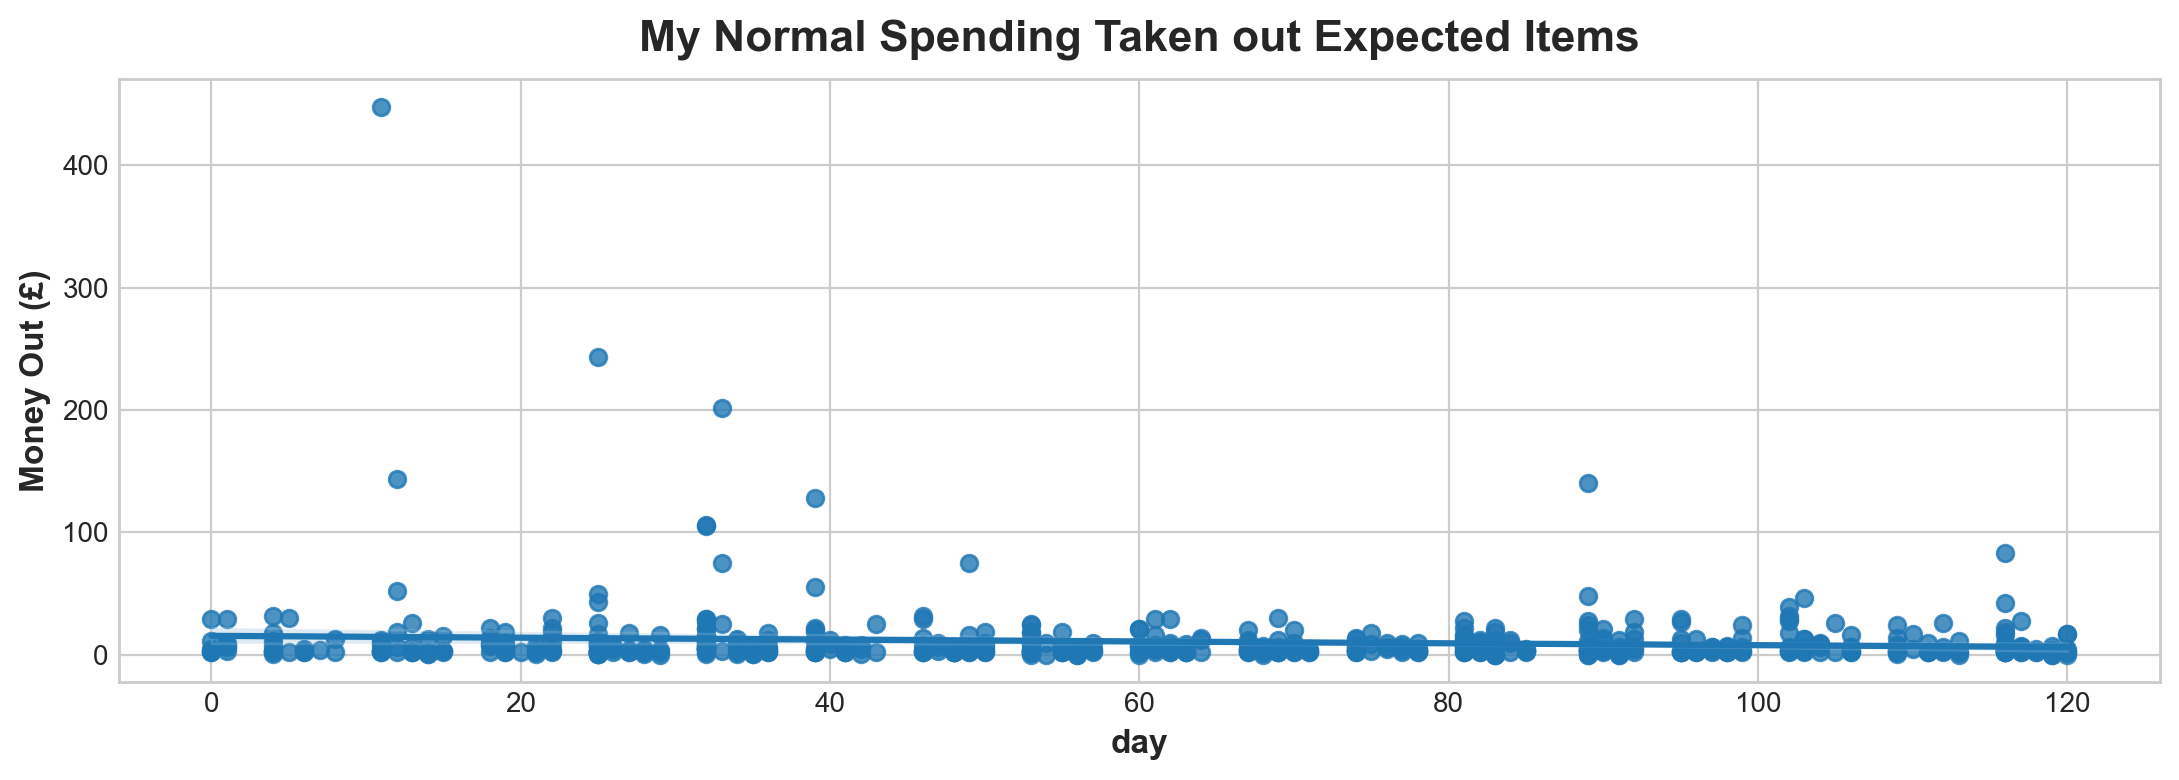

In [10]:
normal_spending = df\
    .sort_values('Money Out (£)', ascending = False)\
    .query('''
           Description != 'STEPHEN GIBSON' & ~Description.str.contains('UKVISA|IMM HEALTH')
           ''')
normal_spending_x = normal_spending.assign(
    day = lambda x:  (x.Date - x.Date.min()).dt.days.astype('float')
)
p = sns.regplot(
    data = normal_spending_x, 
    x = 'day',
    y = 'Money Out (£)'
)
p.set_title('My Normal Spending Taken out Expected Items')
normal_spending.head(10)

In [23]:
import numpy as np

## Use this code for analysing monthly spendings
## This is Actual code
## Directly use df.aveg() is wrong because it indicate per transaction.

## Directly use df.group_by['Day'].sum()....group_by is also wrong
## Becasue the number of days in the period is also wrong.

normal_spending['Money Out (£)']
spending_by_month = normal_spending\
    .assign(
        Month = lambda df: df.Date.dt.to_period('M')
    )\
    .groupby('Month')\
    .agg({
        'Money Out (£)':'sum'
        })\
    .reset_index()\
    .assign(
        Days_in_Month = lambda df: df.Month.dt.days_in_month
    )\
    .assign(
        Average_Spending = lambda df: np.round(df['Money Out (£)'] / df['Days_in_Month'], 2)
    )

,Month,Money Out (£),Days_in_Month,Average_Spending
0,2023-06,1830.0,30,61.00
1,2023-07,1896.0,31,61.16
2,2023-08,1260.0,31,40.65
3,2023-09,1154.0,30,38.47


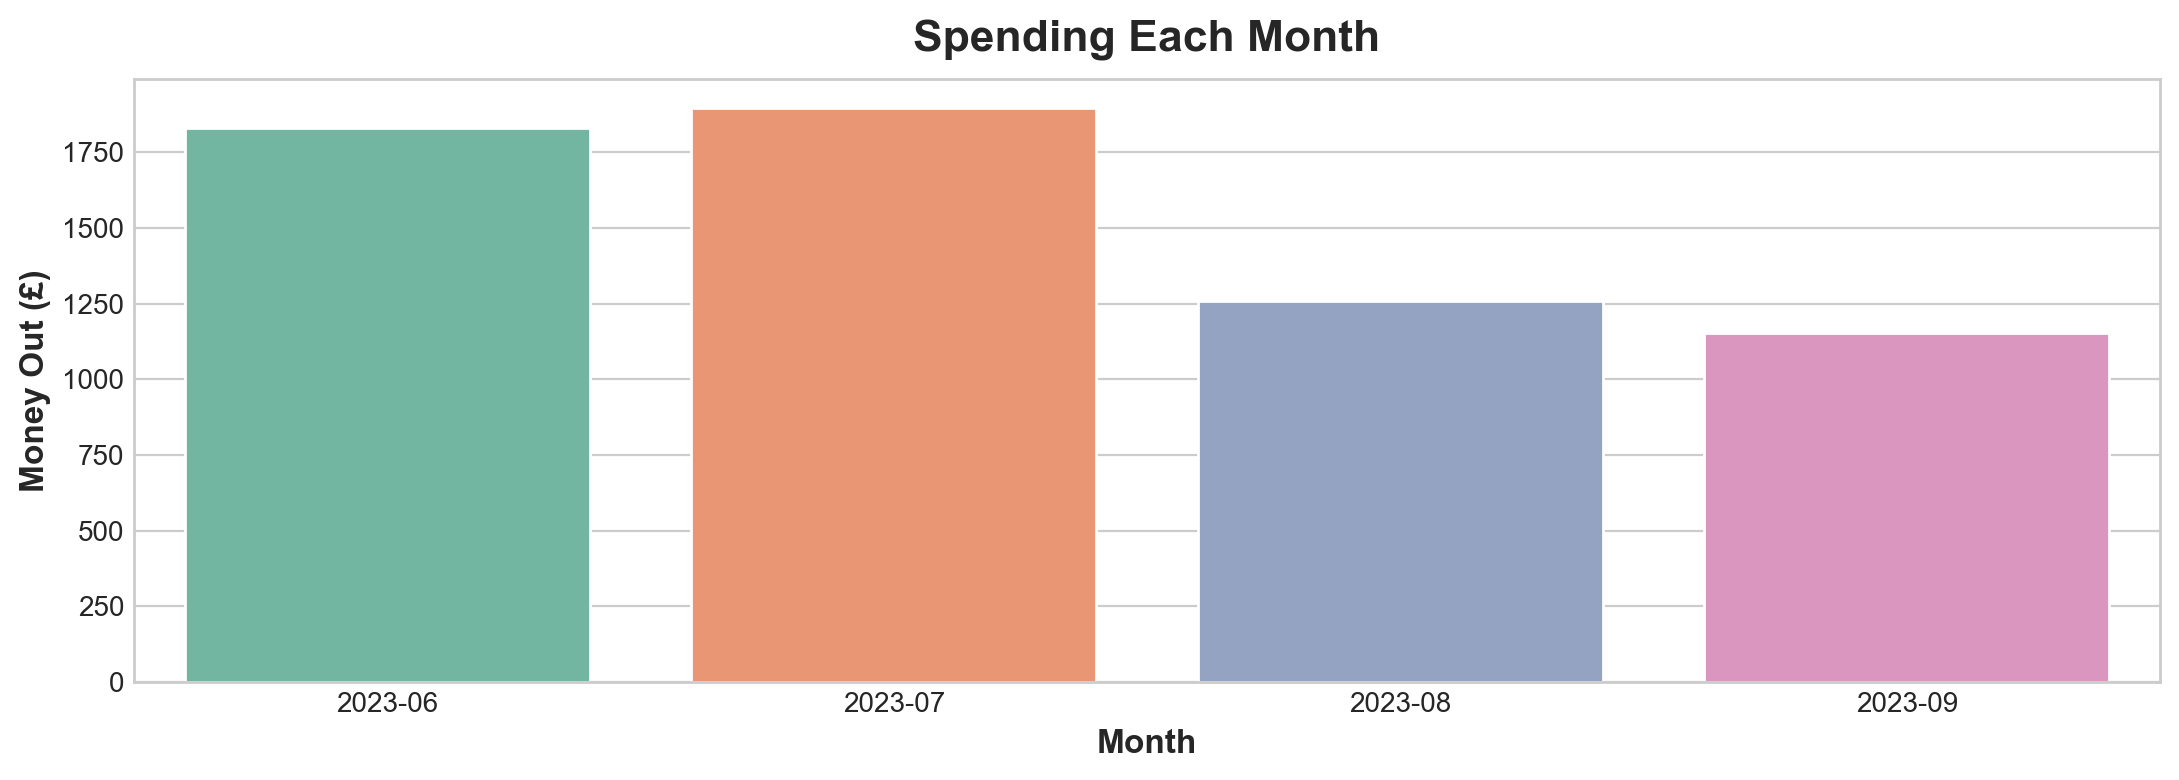

In [35]:
ax = sns.barplot(
    spending_by_month,
    x = 'Month',
    y = 'Money Out (£)',
    palette = 'Set2'
)
ax.set_title('Spending Each Month')
spending_by_month

So far this is the most useful imformation about average day spendings. This is managable amount. We understand that September sepnding is slightly lower but this makes no differences at all.

Next it may-be useful to see how much does monely subscription contributes to daily spending. 

/var/folders/r5/1cdq52mn21zdnqzl0fvp44zw0000gn/T/ipykernel_73070/3736203290.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  normal_spending['Week'] = normal_spending.Date.dt.week
/var/folders/r5/1cdq52mn21zdnqzl0fvp44zw0000gn/T/ipykernel_73070/3736203290.py:16: UserWarning: 
The palette list has fewer values (6) than needed (18) and will cycle, which may produce an uninterpretable plot.
  ax = sns.lineplot(


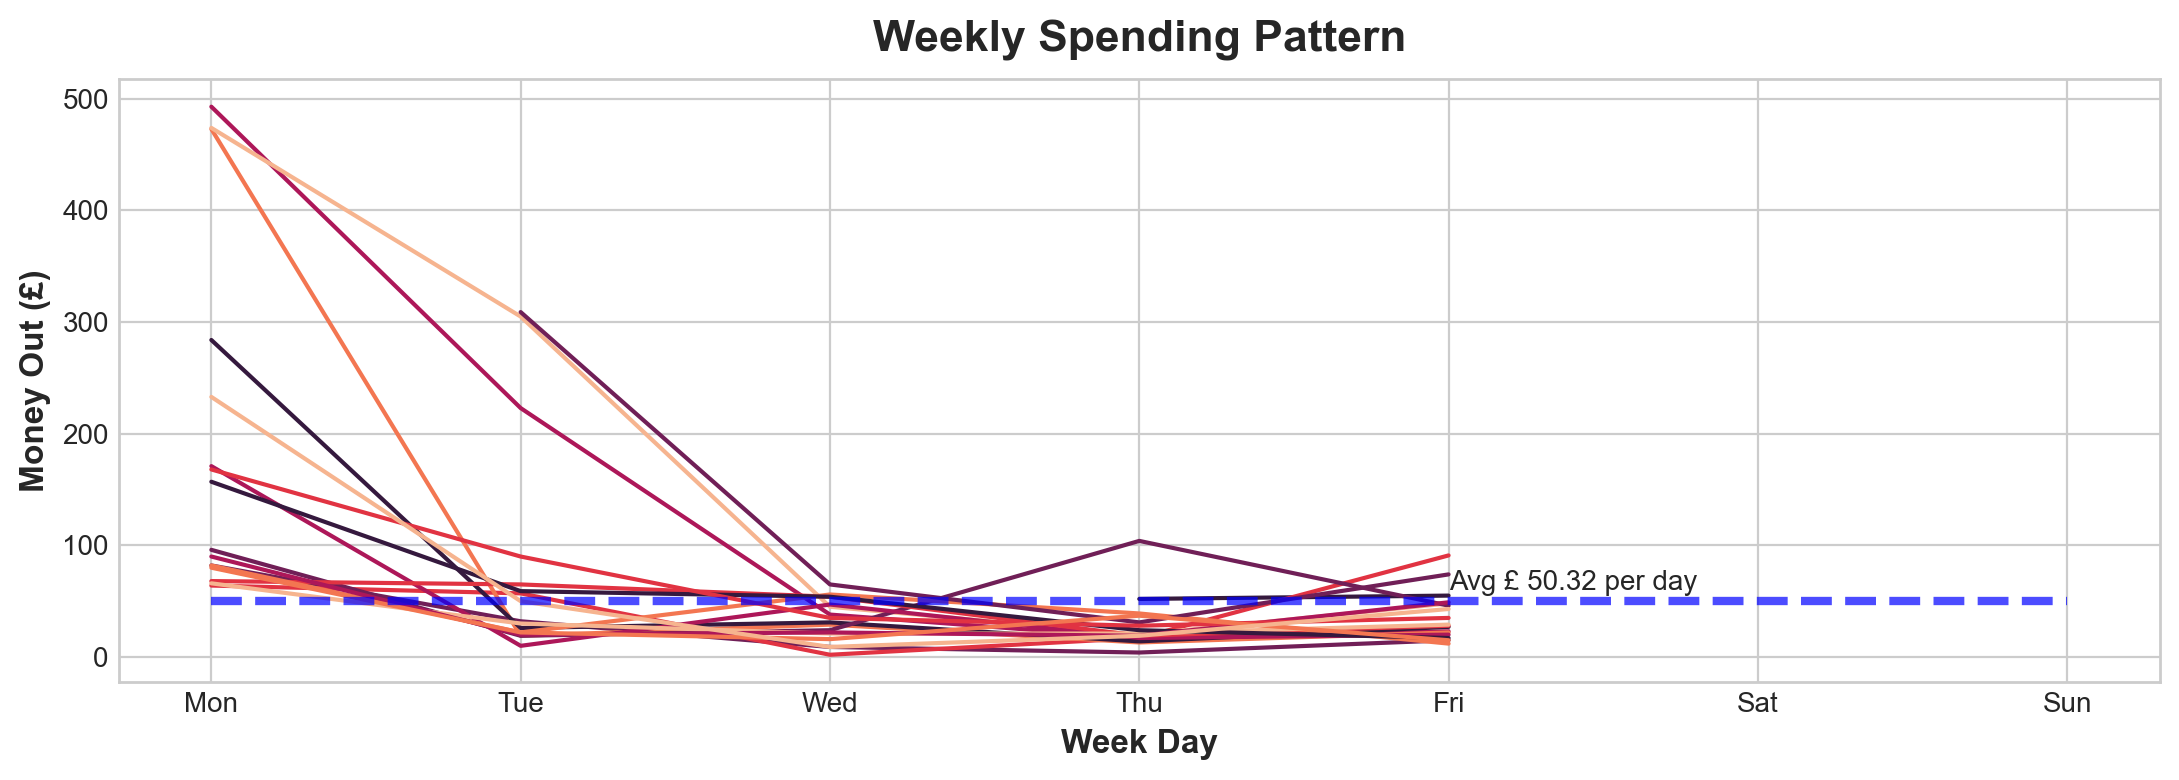

In [36]:
normal_spending['Week Day'] = normal_spending.Date.dt.weekday
# normal_spending['Week'] = normal_spending.Date.dt.isocalendar().week
normal_spending['Week'] = normal_spending.Date.dt.week

average_spending = spending_by_month['Average_Spending'].mean()


daily_spending = (
    normal_spending
    .groupby(['Date','Week','Week Day'])
    .agg({'Money Out (£)':'sum'})
    .reset_index()
)
plette = sns.color_palette("rocket", daily_spending.Week.nunique())
## daily_spending
ax = sns.lineplot(
    data = daily_spending,
    x = 'Week Day',
    y = 'Money Out (£)',
    hue = 'Week',
    palette=sns.color_palette('rocket')
)
ax.set_xticks(
    range(0,7),
    labels = ['Mon', 'Tue', 'Wed', 'Thu','Fri', 'Sat', 'Sun']
)
plt.annotate(
    f"Avg £ {round(average_spending,2)} per day",
    (4, average_spending + 10)
)
sns.lineplot(
    x = [i for i in range(0,7)],
    y = average_spending,
    linewidth = 3, alpha = 0.7, linestyle = 'dashed', color = 'blue'
)
# for plt. plot reference look here: https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html
ax.set_title('Weekly Spending Pattern')
plt.legend([],[], frameon=False)

In [37]:
# The most expensive spending day
daily_spending.sort_values('Money Out (£)', ascending=False)
normal_spending.query("Date == '2023-06-12'").head(3)

,Date,Description,Type,Money In (£),Money Out (£),Balance (£),Week Day,Week
34,2023-06-12,ACUITIS OPTICAL &,DEB,0.0,448.0,3844.0,0,24
30,2023-06-12,MARKS&SPENCER PLC,DEB,0.0,12.0,4307.0,0,24
35,2023-06-12,Zettle_*Sundays,DEB,0.0,10.0,3833.0,0,24


I clearly rememeber going out on Saturday not Sunday. Weekwise sepnding pattern is not registered correctly. There are lag between a transaction is made and when a transaction is received.

Meaning there are no point dive into time spending too much. But at least we know its possible same spending will be in the same day.

## Try Categorized My Data and See What is Happenging

In [38]:
df\
    .value_counts(['Description', 'Type'])\
    .reset_index()\
    .rename({
        0:'Occurance'
    }, axis=1
    )

,Description,Type,Occurance
0,STGCOACH/CTYLINK,DEB,111
1,COSTA COFFEE 43011,DEB,72
2,MARKS&SPENCER PLC,DEB,60
3,TESCO STORES 2487,DEB,37
4,APPLE,DEB,23
...,...,...,...
112,SUMUP *CALIBRE BA,DEB,1
113,SUMUP *OJHAIR,DEB,1
114,Shutters at The Go,DEB,1
115,SumUp *Glow time,DEB,1


In [39]:
df\
    .value_counts('Type')\
    .reset_index()

,Type,0
0,DEB,555
1,DD,9
2,FPO,6
3,BGC,4
4,FPI,1


In [40]:
# FPO seems to be stand for direct transfer
df.query('''
Type == 'FPO'
''')

,Date,Description,Type,Money In (£),Money Out (£),Balance (£)
96,2023-06-26,STEPHEN GIBSON,FPO,0.0,350.0,2521.0
210,2023-07-17,CHARLOTTE JOHNSON,FPO,0.0,29.0,3204.0
288,2023-08-01,STEPHEN GIBSON,FPO,0.0,350.0,4422.0
384,2023-08-22,JACK WEST,FPO,0.0,10.0,3707.0
407,2023-08-29,STEPHEN GIBSON,FPO,0.0,350.0,3208.0
569,2023-09-29,STEPHEN GIBSON,FPO,0.0,350.0,5816.0


In [41]:
# How much do I spend on grossary and food? 
df.query(
    "Description.str.contains('MARKS&SPENCER PLC') or "
    "Description.str.contains('TESCO') or "
    "Description.str.contains('SAINSBURYS') or "
    "Description.str.contains('CO-OP GROUP') "
)\
    .assign(
        Month = lambda df: df.Date.dt.to_period('M')
    )\
    .groupby(["Month"])\
    .agg({'Money Out (£)':sum})

,Money Out (£)
Month,
2023-06,285.0
2023-07,240.0
2023-08,231.0
2023-09,288.0


In [12]:
from numpy import where
df.assign(
    category = lambda df: where(
        df.Description.str.contains(
            r'MARKS&SPENCER PLC|TESCO|SAINSBURYS|CO-OP GROUP'
            ),
        'Food & Grocery',
        where(
            df.Description.str.contains(r'STGCOACH'),
            'Transport',
            where(
                df.Description.str.contains(r'COSTA COFFEE|PRET A MANGER'),
                'Cafe',
                'Other'
            )
        )
        )
)\
    .query(
        "category.str.contains(r'Other')"
    )\
    .filter(['Description'])\
    .value_counts()\
    .reset_index()

,Description,0
0,APPLE,23
1,WATERSTONES,13
2,EXETER CITY COUNCI,8
3,iFood Thai Taste,7
4,V H GRADDON SONS V,7
...,...,...
101,Nike GBP,1
102,NO ORDINARY DESIGN,1
103,MCDONALDS,1
104,LLL ATHLETICA UK L,1


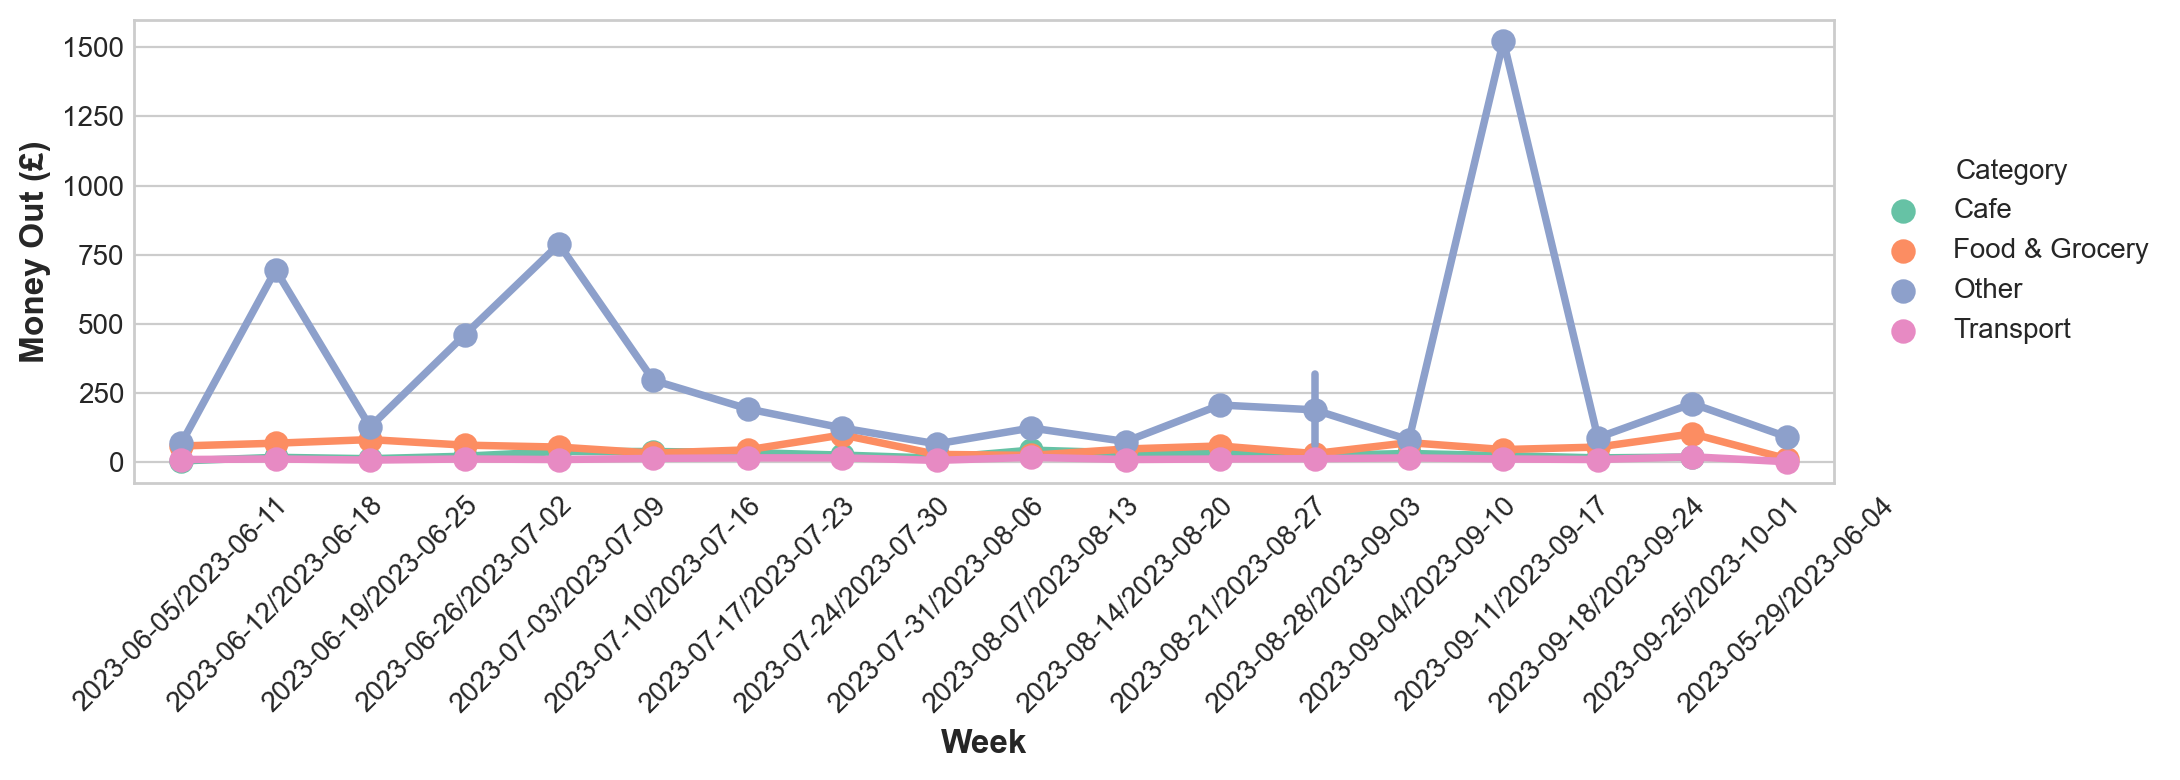

In [22]:
# # Alternative ways of mapping categorical variable in python
# import re
# df['Description'].map(
#     lambda x: 'SUBSCRIPTION' if re.match('EXETER', x) else 'OTHER'
# )
import re
# Define a Mapping Function For More Readable Data Cleaning
def which_cateogry(x):
    label_category = [
        # This directory defines what to map, what to look for, 
        # Order matters, you should order them based on how confident you are.
        ('MARKS&SPENCER PLC|TESCO|SAINSBURYS|CO-OP GROUP','Food & Grocery'),
        ('STGCOACH','Transport'),
        ('COSTA COFFEE|PRET A MANGER','Cafe'),
        ('STEPHEN GIBSON|UKVISA|\*IMM HEALTH','Rent & Essential')
    ]
    for match_key, content in label_category:
        if re.match(match_key, x):
            return(content)
    return('Other')

# Create Analytic Dataframe Chunk
spending_breakdown = (
    df.assign(
        Category = lambda df: df['Description'].map(which_cateogry),
        Month = lambda df: df.Date.dt.to_period('M'),
        Week = lambda df: df.Date.dt.to_period('W')
        )
)

spending_periodic_breakdown = (
    spending_breakdown
      .groupby(['Category','Month','Week'])
      .agg({
          'Money Out (£)':sum,
          'Description':lambda x: x.value_counts().to_json()
          })
      .drop('Rent & Essential', axis = 0)
)

# Register for ploting to use 
ax = plt.gca() # Get Current Plotting
pd.plotting.register_matplotlib_converters()
ax.xaxis.freq = spending_periodic_breakdown.index.levels[2].freq
plt.xticks(rotation=45)

# Two Layer Plot
sns.lineplot(
    data = spending_periodic_breakdown.reset_index(),
    x = 'Week',
    y = 'Money Out (£)',
    hue = 'Category',
    palette = 'Set2',
    legend = False # Remove the first plot so ledgend don't overlay
)
sns.pointplot(
    data = spending_periodic_breakdown.reset_index(),
    x = 'Week',
    y = 'Money Out (£)',
    hue = 'Category',
    palette = 'Set2'
)
sns.move_legend(
    plt.gca(), loc='center right', frameon=False, bbox_to_anchor=(1.2, .5)
)

In [20]:
spending_periodic_breakdown.loc[('Other', '2023-09'),:]

,Money Out (£),Description
Week,,
2023-08-28/2023-09-03,61.0,"{""EXETER CITY COUNCI"":2,""WATERSTONES"":2,""Zettl..."
2023-09-04/2023-09-10,81.0,"{""PAYPAL *NETFLIX"":1,""TCH EXETER"":1,""MAJA DELI..."
2023-09-11/2023-09-17,1522.0,"{""SQ *ARTIGIANO ESPR"":2,""PAYPAL *IMM HEALTH"":1..."
2023-09-18/2023-09-24,89.0,"{""Zettle_*Topsham Br"":2,""WATERSTONES"":2,""BURGE..."
2023-09-25/2023-10-01,212.0,"{""APPLE"":3,""IKEA LTD 548 EXETE"":2,""TCH EXETER""..."


In [21]:
# This code chunk is used to set up for Dash App
#df.to_csv('data/bank-data.csv')
import pandas as pd
# df.to_csv('data/bank-data.csv',index=False)
# df.to_parquet('data/bank-data.parquet')
df=pd.read_parquet('data/bank-data.parquet')
schema=df.dtypes.to_dict()
type(schema['Date'])

numpy.dtype[datetime64]

In [7]:
darkMode=False
def dym(class_name, darkMode=darkMode):
    return class_name if darkMode else class_name + ' dark-theme'

In [11]:
darkMode=True
dym('myclass')

'myclass dark-theme'